In [5]:
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt
import timm
import random
import numpy as np
import os
import pandas as pd
from PIL import Image
import torch

In [6]:
SEED = 42
random.seed(SEED)
numpy_seed = SEED
np.random.seed(numpy_seed)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
train_img_dir     = "images/ISIC-2017_Training_Data"
val_img_dir       = "images/ISIC-2017_Validation_Data"
test_img_dir      = "images/ISIC-2017_Test_v2_Data"
train_csv         = "images/ISIC-2017_Training_Part3_GroundTruth.csv"
val_csv           = "images/ISIC-2017_Validation_Part3_GroundTruth.csv"
test_csv          = "images/ISIC-2017_Test_v2_Part3_GroundTruth.csv"
batch_size        = 32
device            = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
def create_transforms():
    train_t = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        transforms.RandomErasing(p=0.5)
    ])
    val_t = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
    return train_t, val_t

In [9]:
def load_image_tensors(df, img_dir, transform):
    imgs, labels = [], []
    for row in df.itertuples(index=False, name=None):
        img_id, label = str(row[0]), int(row[1])
        for ext in ('.jpg','.jpeg'):
            path = os.path.join(img_dir, img_id+ext)
            if os.path.exists(path):
                imgs.append(transform(Image.open(path).convert('RGB')))
                labels.append(label)
                break
    return torch.stack(imgs), torch.tensor(labels, dtype=torch.long)

In [10]:
train_t, val_t = create_transforms()

df_all = pd.read_csv(train_csv)

imgs_all, labs_all = load_image_tensors(df_all, train_img_dir, train_t)

class_counts = df_all.iloc[:,1].value_counts().sort_index()

sample_weights = [1.0/class_counts[int(l)] for l in labs_all]
g = torch.Generator().manual_seed(SEED)
sampler_full = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True, generator=g)
train_loader = DataLoader(TensorDataset(imgs_all, labs_all), batch_size=batch_size, sampler=sampler_full, num_workers=4)


In [11]:

df_val = pd.read_csv(val_csv)
imgs_v, labs_v = load_image_tensors(df_val, val_img_dir, val_t)
val_loader = DataLoader(TensorDataset(imgs_v, labs_v), batch_size=batch_size, shuffle=False, num_workers=2)

df_test = pd.read_csv(test_csv)
imgs_te, labs_te = load_image_tensors(df_test, test_img_dir, val_t)
test_loader = DataLoader(TensorDataset(imgs_te, labs_te), batch_size=batch_size, shuffle=False, num_workers=2)

In [12]:

weights_tensor = torch.tensor([class_counts.max()/class_counts[i] for i in class_counts.index], dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)


model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [13]:
best_auc, no_improve = 0.0, 0
history = []
patience = 3
for epoch in range(1,21):
        model.train()
        for X,y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
            optimizer.step()
        scheduler.step()


        model.eval()
        probs, labs = [], []
        with torch.no_grad():
            for X,y in val_loader:
                X = X.to(device)
                p = torch.softmax(model(X),dim=1)[:,1].cpu()
                probs.extend(p.tolist()); labs.extend(y.tolist())
        auc = roc_auc_score(labs,probs)
        history.append(auc)
        print(f"Epoch {epoch} — Val AUC: {auc:.4f}")
        if auc > best_auc:
            best_auc = auc; no_improve = 0
            torch.save(model.state_dict(),'best_model.pt')
        else:
            no_improve += 1
            if no_improve>=patience:
                print("Early stopping")
                break

Epoch 1 — Val AUC: 0.7975
Epoch 2 — Val AUC: 0.7806
Epoch 3 — Val AUC: 0.7578
Epoch 4 — Val AUC: 0.7811
Early stopping


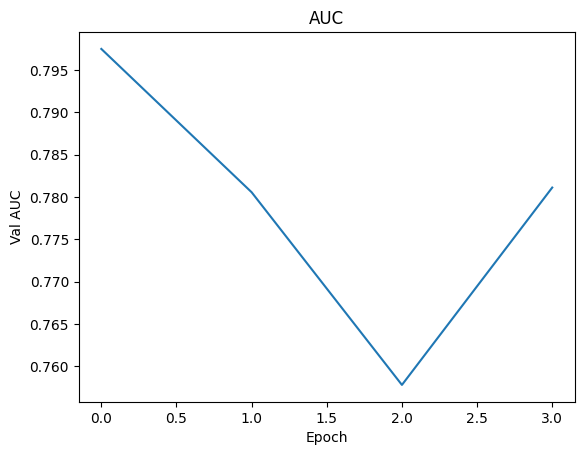

In [15]:

plt.figure()
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Val AUC')
plt.title('AUC')
plt.savefig('auc.png')
plt.show()



In [16]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
probs, labs = [], []
with torch.no_grad():
        for X,y in test_loader:
            p = torch.softmax(model(X.to(device)),dim=1)[:,1].cpu()
            probs.extend(p.tolist()); labs.extend(y.tolist())
print('Test AUC:',roc_auc_score(labs,probs))
preds = [1 if p>=0.5 else 0 for p in probs]

print(classification_report(labs,preds,target_names=['non-melanoma','melanoma']))

Test AUC: 0.7074463378811204
              precision    recall  f1-score   support

non-melanoma       0.88      0.71      0.79       483
    melanoma       0.34      0.62      0.44       117

    accuracy                           0.69       600
   macro avg       0.61      0.66      0.61       600
weighted avg       0.78      0.69      0.72       600

